In [1]:
import os

from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random as python_random
import glob

In [2]:
# controlling parameters
sampling = False
n_samples = 1000 # only used if sampling=True
Google_extra_weight = 1
save_file_name = '../train_val_test_sgkf_Feb26_allFiles_sum1.csv'
no_weight = False

In [3]:
# scan data directories

nature_file_list = []
nature_file_list += glob.glob('../data/interim/AmbisonicSoundLibrary/nature/*')
nature_file_list += glob.glob('../data/interim/GoogleAudioSet/Outside, rural or natural/*')
nature_file_list += glob.glob('../data/interim/youtube/NomadicAmbience_nature/*')
nature_file_list += glob.glob('../data/interim/S2L_LULC/non_urban/*')
nature_file_list += glob.glob('../data/interim/S2L_LULC/urban_0_25/*')

city_file_list = []
city_file_list += glob.glob('../data/interim/GoogleAudioSet/Outside, urban or manmade/*')
city_file_list += glob.glob('../data/interim/youtube/NomadicAmbience_city/*')
# city_file_list += glob.glob('../data/interim/S2L_LULC/urban_26_100/*')

# these two directories have way too many files, which will biase the training toward the difference between these 2 them rather the category
NS_file_list = glob.glob('../data/interim/youtube/NatureSoundscapes/*')
SONYC_file_list = glob.glob('../data/interim/SONYC/**/*.pkl')

import random
random.seed(23)



if sampling:
    # sampling
    NS_file_list_sampled = random.sample(NS_file_list, n_samples)
    nature_file_list += NS_file_list_sampled

    SONYC_file_list_sampled = random.sample(SONYC_file_list, len(nature_file_list)-len(city_file_list)) # compensate the difference
    city_file_list += SONYC_file_list_sampled 
else:
   # use all files
    nature_file_list += NS_file_list
    city_file_list += SONYC_file_list     



nature_source_list = ['nature_'+i.rsplit('/', 3)[1]+'/'+i.rsplit('/', 3)[2] for i in nature_file_list]
city_source_list = ['city_'+i.rsplit('/', -1)[3] for i in city_file_list]

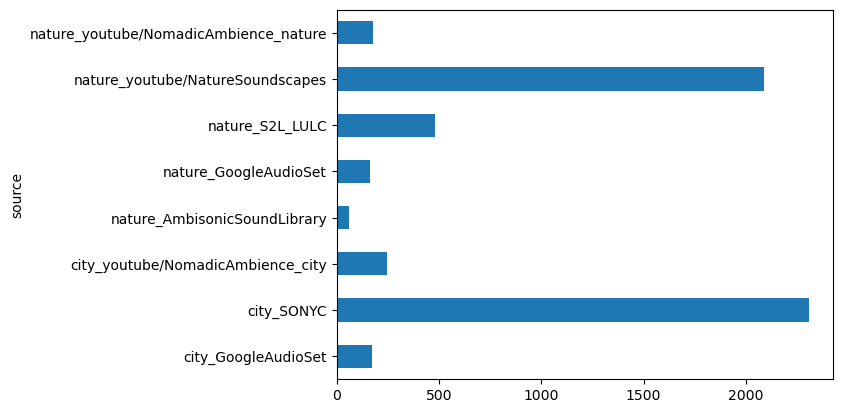

In [4]:
# sorting out the sources of data files
nature_df = pd.DataFrame({'file': nature_file_list, 'source': nature_source_list, 'category': 0})
city_df = pd.DataFrame({'file': city_file_list, 'source': city_source_list, 'category': 1})
df_all = pd.concat([nature_df, city_df], ignore_index=True)

df_all['source'] = df_all['source'].str.replace('nature_AmbisonicSoundLibrary/nature','nature_AmbisonicSoundLibrary')
df_all['source'] = df_all['source'].str.replace('nature_GoogleAudioSet/Outside, rural or natural','nature_GoogleAudioSet')
df_all['source'] = df_all['source'].str.replace('city_youtube','city_youtube/NomadicAmbience_city')
df_all['source'] = df_all['source'].str.replace('nature_S2L_LULC/urban_0_25','nature_S2L_LULC')
df_all['source'] = df_all['source'].str.replace('nature_S2L_LULC/non_urban','nature_S2L_LULC')


source_count = df_all.groupby(['source'])['file'].count()
ax = source_count.plot.barh()
plt.show()

In [5]:
# make the weights as the inverse of the number of files per source
df_all['weight'] = df_all['source'].apply(lambda s: 1/source_count.loc[s])

# make the samples in the GoogleAudioSet to be ? times, as they were all from different sources
df_all.loc[df_all['source'].str.contains('GoogleAudioSet'),'weight'] = df_all.loc[df_all['source'].str.contains('GoogleAudioSet'),'weight']*Google_extra_weight
df_all.groupby(['source'])['weight'].sum()

if no_weight:
    # just set all the weights to 1
    df_all['weight'] = 1

In [6]:
# extract the youtube ID of the file out and put it as 'file_group'
df_all['file_group'] = df_all['file'].apply(lambda st: st[st.find('/youtube/')+1:st.rfind("_")])

# for the rows that were not extracted from youtube, replace the 'file_group' by 'file', as they are all from different sources
df_all.loc[~df_all['file_group'].str.contains('youtube'), 'file_group'] = df_all.loc[~df_all['file_group'].str.contains('youtube'), 'file']
df_all

,file,source,category,weight,file_group
0,../data/interim/AmbisonicSoundLibrary/nature/W...,nature_AmbisonicSoundLibrary,0,0.017241,../data/interim/AmbisonicSoundLibrary/nature/W...
1,../data/interim/AmbisonicSoundLibrary/nature/R...,nature_AmbisonicSoundLibrary,0,0.017241,../data/interim/AmbisonicSoundLibrary/nature/R...
2,../data/interim/AmbisonicSoundLibrary/nature/A...,nature_AmbisonicSoundLibrary,0,0.017241,../data/interim/AmbisonicSoundLibrary/nature/A...
3,../data/interim/AmbisonicSoundLibrary/nature/W...,nature_AmbisonicSoundLibrary,0,0.017241,../data/interim/AmbisonicSoundLibrary/nature/W...
4,../data/interim/AmbisonicSoundLibrary/nature/L...,nature_AmbisonicSoundLibrary,0,0.017241,../data/interim/AmbisonicSoundLibrary/nature/L...
...,...,...,...,...,...
5677,../data/interim/SONYC/audio-5/40_004271.pkl,city_SONYC,1,0.000433,../data/interim/SONYC/audio-5/40_004271.pkl
5678,../data/interim/SONYC/audio-5/27_000199.pkl,city_SONYC,1,0.000433,../data/interim/SONYC/audio-5/27_000199.pkl
5679,../data/interim/SONYC/audio-5/08_017512.pkl,city_SONYC,1,0.000433,../data/interim/SONYC/audio-5/08_017512.pkl
5680,../data/interim/SONYC/audio-5/03_009730.pkl,city_SONYC,1,0.000433,../data/interim/SONYC/audio-5/03_009730.pkl


In [7]:
from sklearn.model_selection import StratifiedGroupKFold

# Split the data into folds using StratifiedKFold
sgkf = StratifiedGroupKFold(n_splits=10, shuffle=True, random_state=23)
for fold, (train_idx, val_idx) in enumerate(sgkf.split(X=df_all, y=df_all['source'], groups=df_all['file_group'])):
    # Assign the fold number to each row in the DataFrame
    df_all.loc[val_idx, 'fold'] = fold
    
df_all['fold'] = df_all['fold'].astype('int')

# need to shuffle the rows before deep learning
df_all = df_all.sample(frac=1, random_state=23).reset_index(drop=True) 
df_all

,file,source,category,weight,file_group,fold
0,../data/interim/youtube/NatureSoundscapes/6LpA...,nature_youtube/NatureSoundscapes,0,0.000479,youtube/NatureSoundscapes/6LpAnfislTc,6
1,../data/interim/youtube/NomadicAmbience_nature...,nature_youtube/NomadicAmbience_nature,0,0.005714,youtube/NomadicAmbience_nature/wlCrnlQ5ofE,0
2,../data/interim/SONYC/audio-10/05_027168.pkl,city_SONYC,1,0.000433,../data/interim/SONYC/audio-10/05_027168.pkl,4
3,../data/interim/SONYC/audio-13/32_019485.pkl,city_SONYC,1,0.000433,../data/interim/SONYC/audio-13/32_019485.pkl,8
4,../data/interim/SONYC/audio-13/33_016321.pkl,city_SONYC,1,0.000433,../data/interim/SONYC/audio-13/33_016321.pkl,5
...,...,...,...,...,...,...
5677,"../data/interim/GoogleAudioSet/Outside, urban ...",city_GoogleAudioSet,1,0.005882,"../data/interim/GoogleAudioSet/Outside, urban ...",9
5678,../data/interim/youtube/NatureSoundscapes/gEqK...,nature_youtube/NatureSoundscapes,0,0.000479,youtube/NatureSoundscapes/gEqKnRu15bI,2
5679,../data/interim/youtube/NatureSoundscapes/PFtx...,nature_youtube/NatureSoundscapes,0,0.000479,youtube/NatureSoundscapes/PFtxRv6GcFw,8
5680,../data/interim/SONYC/audio-17/03_001923.pkl,city_SONYC,1,0.000433,../data/interim/SONYC/audio-17/03_001923.pkl,8


In [8]:
df_all.to_csv(save_file_name)